# LGT Quick Start

LGT stands for Local and Global Trend, which is an important model type in orbit package. In the model equation, there is a local trend term and a global trend term.

In this notebook we will show how to use Orbit LGT models with the US unemployment claims data.

**Note: Negative response values are not allowed in LGT model, due to the existence of the global trend term.**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from orbit.models import LGT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_iclaims

from orbit.utils.plot import get_orbit_style
plt.style.use(get_orbit_style())

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job) from Jan 2010 - June 2018. 
This aims to mimick the dataset from the paper [Predicting the Present with Bayesian Structural Time Series](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf) by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).
Note that dataset is transformed by natural log before fitting in order to be fitted as a multiplicative model.

In [3]:
# load data
df = load_iclaims()

# define date and response column
DATE_COL = 'week'
RESPONSE_COL = 'claims'

df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [4]:
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


### Train / Test Split

In [5]:
test_size = 52

train_df = df[:-test_size]
test_df = df[-test_size:]

In [6]:
train_df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


## LGT Model

In orbit, we have three types of LGT models, `LGTMAP`, `LGTAggregated` and  `LGTFull`.
Orbit follows the sklearn model API. We can create an instance of the Orbit class and then call its fit and predict methods.

### LGT-MAP

LGT model for MAP (Maximum a Posteriori) prediction

In [84]:
lgt = LGT(response_col=RESPONSE_COL,
          date_col=DATE_COL,
          regressor_col=['sp500'],
          seasonality=52,
          estimator='stan-map',
          seed=8888)

In [85]:
%%time
lgt.fit(df=train_df)

CPU times: user 115 ms, sys: 4.64 ms, total: 119 ms
Wall time: 119 ms


In [86]:
lgt.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,sp500,Regular,-0.12971


In [53]:
predicted_df = lgt.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.418015,12.470020,-0.009206,-0.042799
1,2017-07-09,12.535814,12.466968,0.113440,-0.044594
2,2017-07-16,12.376365,12.465180,-0.043529,-0.045286
3,2017-07-23,12.230366,12.463524,-0.187895,-0.045263
4,2017-07-30,12.182085,12.461882,-0.234289,-0.045509


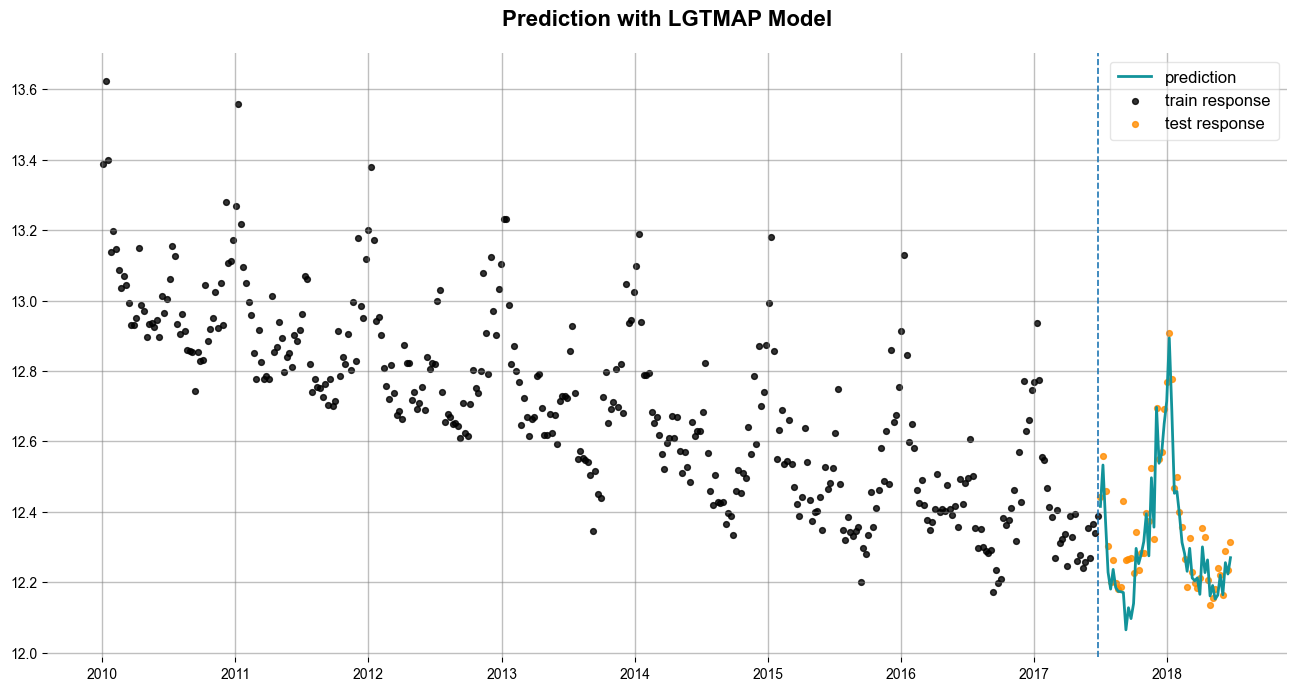

In [19]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,  
                        test_actual_df=test_df,
                        title='Prediction with LGTMAP Model')

### LGT-MCMC

LGT model for full prediction. In full prediction, the prediction occurs as a function of each parameter posterior sample, and the prediction results are aggregated after prediction. Prediction will always return the median (aka 50th percentile) along with any additional percentiles that are specified.

In [62]:
lgt = LGT(response_col=RESPONSE_COL,
          date_col=DATE_COL,
          estimator='stan-mcmc',
          regressor_col=['sp500'],
          seasonality=52,
          seed=8888)

In [63]:
%%time
lgt.fit(df=train_df, point_method=None)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 67.7 ms, sys: 65.3 ms, total: 133 ms
Wall time: 8.51 s


In [64]:
lgt.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,sp500,Regular,-0.095033


In [65]:
predicted_df = lgt.predict(df=test_df, point_method=None, decompose=True)
predicted_df.tail()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
47,2018-05-27,12.128566,12.228632,12.343290,12.291889,12.407355,12.565233,-0.236675,-0.125514,-0.087514,-0.097213,-0.043047,0.002244
48,2018-06-03,12.053774,12.179821,12.285252,12.272002,12.422617,12.554848,-0.294289,-0.186937,-0.150488,-0.100670,-0.044578,0.002324
49,2018-06-10,12.159346,12.261654,12.395877,12.293383,12.418915,12.546787,-0.198603,-0.091566,-0.054387,-0.100718,-0.044600,0.002325
50,2018-06-17,12.113395,12.228578,12.351798,12.278309,12.411219,12.547791,-0.228737,-0.122882,-0.083590,-0.098797,-0.043749,0.002280
51,2018-06-24,12.157121,12.280500,12.398495,12.244689,12.420516,12.567333,-0.179964,-0.074889,-0.034329,-0.095934,-0.042481,0.002214


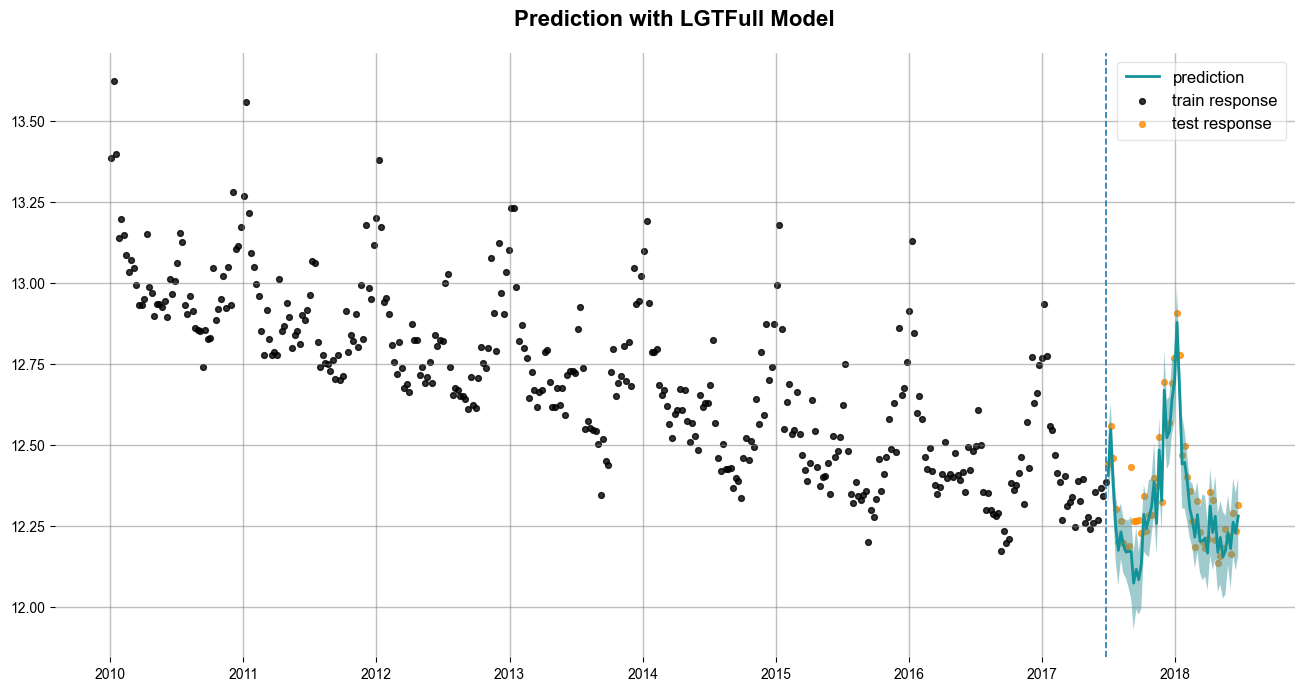

In [66]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                        title='Prediction with LGTFull Model')

In [67]:
lgt.fit(df=train_df, point_method='mean')
predicted_df = lgt.predict(df=test_df, decompose=True)
predicted_df.tail()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,week,prediction,trend,seasonality,regression
47,2018-05-27,12.211622,12.406043,-0.154295,-0.040126
48,2018-06-03,12.147117,12.404127,-0.215458,-0.041553
49,2018-06-10,12.240371,12.402211,-0.120267,-0.041573
50,2018-06-17,12.208639,12.400296,-0.150877,-0.040780
51,2018-06-24,12.256222,12.398380,-0.102561,-0.039598


In [68]:
lgt.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,sp500,Regular,-0.088583


In [69]:
lgt.fit(df=train_df, point_method='median')
predicted_df = lgt.predict(df=test_df, decompose=True)
predicted_df.tail()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,week,prediction,trend,seasonality,regression
47,2018-05-27,12.239043,12.422860,-0.145461,-0.038356
48,2018-06-03,12.174117,12.421437,-0.207600,-0.039721
49,2018-06-10,12.267429,12.420014,-0.112845,-0.039740
50,2018-06-17,12.236034,12.418591,-0.143575,-0.038981
51,2018-06-24,12.283610,12.417168,-0.095706,-0.037852


In [70]:
lgt.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,sp500,Regular,-0.084677


### LGT-SVI

In [88]:
lgt = LGT(response_col=RESPONSE_COL,
          date_col=DATE_COL,
          estimator='pyro-svi',
          regressor_col=['sp500'],
          seasonality=52,
          seed=8888,
          num_steps=101)

In [89]:
%%time
lgt.fit(df=train_df, point_method=None)

INFO:root:Guessed max_plate_nesting = 2


CPU times: user 19.4 s, sys: 1.14 s, total: 20.5 s
Wall time: 19.3 s


In [90]:
lgt.get_regression_coefs()

,regressor,regressor_sign,coefficient
0,sp500,Regular,-0.079233


In [91]:
predicted_df = lgt.predict(df=test_df, point_method=None, decompose=True)
predicted_df.tail()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
47,2018-05-27,12.134188,12.239194,12.345663,12.293881,12.433754,12.555211,-0.226589,-0.153846,-0.110348,-0.080082,-0.035890,0.017217
48,2018-06-03,12.067673,12.174843,12.315627,12.303840,12.436522,12.590489,-0.289718,-0.216006,-0.170248,-0.082930,-0.037167,0.017829
49,2018-06-10,12.151177,12.274897,12.367586,12.302466,12.445126,12.549077,-0.193503,-0.119538,-0.078269,-0.082970,-0.037185,0.017838
50,2018-06-17,12.126432,12.247311,12.345989,12.310941,12.447040,12.554084,-0.223979,-0.150387,-0.109883,-0.081387,-0.036475,0.017497
51,2018-06-24,12.156756,12.296717,12.396728,12.298664,12.426746,12.567291,-0.175204,-0.102026,-0.061579,-0.079028,-0.035418,0.016990


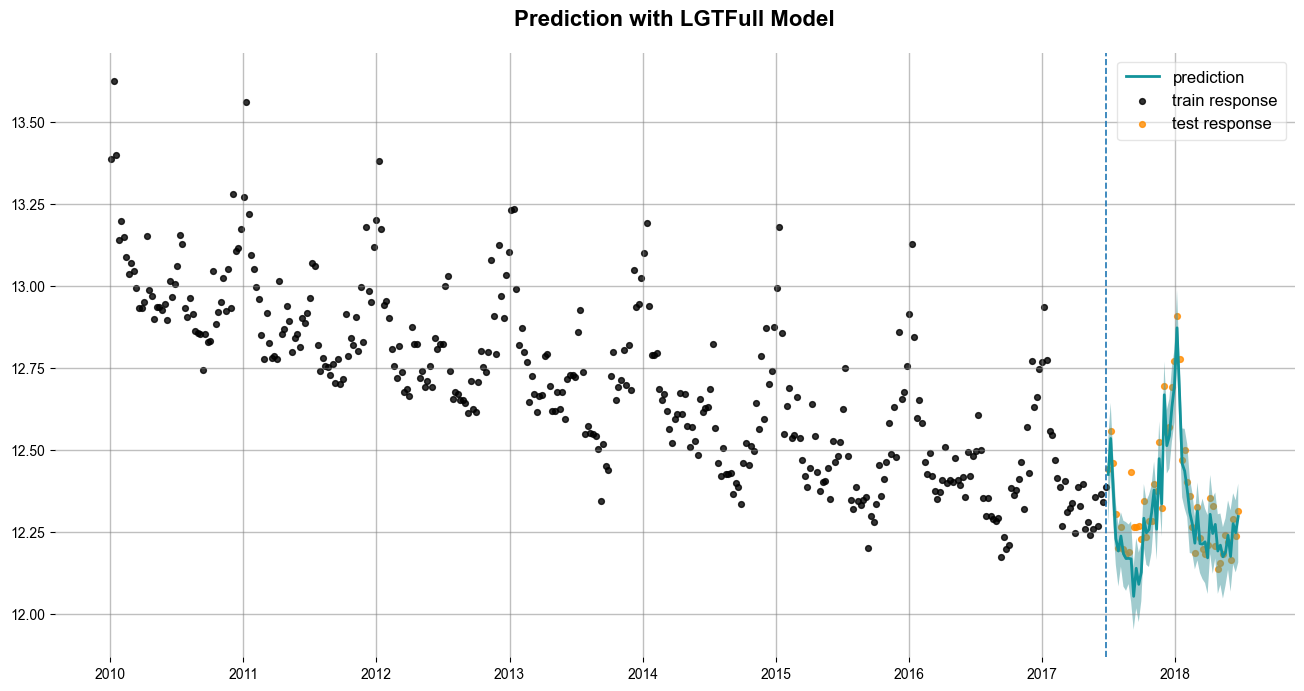

In [92]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                        title='Prediction with LGTFull Model')

In [93]:
lgt.fit(df=train_df, point_method='mean')
predicted_df = lgt.predict(df=test_df, decompose=True)
predicted_df.tail()

INFO:root:Guessed max_plate_nesting = 2


,week,prediction,trend,seasonality,regression
47,2018-05-27,12.238239,12.431259,-0.160223,-0.032796
48,2018-06-03,12.175089,12.429819,-0.220767,-0.033963
49,2018-06-10,12.268645,12.428380,-0.125755,-0.033979
50,2018-06-17,12.237186,12.426940,-0.156423,-0.033331
51,2018-06-24,12.285014,12.425500,-0.108122,-0.032365


In [94]:
lgt.fit(df=train_df, point_method='median')
predicted_df = lgt.predict(df=test_df, decompose=True)
predicted_df.tail()

INFO:root:Guessed max_plate_nesting = 2


,week,prediction,trend,seasonality,regression
47,2018-05-27,12.242491,12.432228,-0.153846,-0.035890
48,2018-06-03,12.177768,12.430941,-0.216006,-0.037167
49,2018-06-10,12.272932,12.429655,-0.119538,-0.037185
50,2018-06-17,12.241506,12.428368,-0.150387,-0.036475
51,2018-06-24,12.289638,12.427082,-0.102026,-0.035418
